###(**A**) **Στοιχεία** **Ομάδος**

Η παρακάτω μελέτη διεξήχθη από την ομάδα ΜΑ7:  
**ΣΠΥΡΟΥ ΝΙΚΟΛΑΟΣ (03116201)  
ΠΕΠΠΑΣ ΠΑΝΑΓΙΩΤΗΣ (03115146)  
ΚΟΝΤΟΓΙΑΝΝΗΣ ΑΝΔΡΕΑΣ (03115187)**

###**(Β) Εισαγωγή του Dataset**


Θα μελετήσουμε το Β11 dataset, δηλαδή το Νomao Dataset απο το UCI Machine Learning Repository.To Nomao είναι μία μηχανή αναζήτησης που συλλέγει δεδομένα σχετικά με μέρη από διάφορες πηγές στο διαδίκτυο όπως τα ονομάτα των περιοχών, διευθύνσεις, τηλέφωνα,γεωγραφικές συντεταγμένες, fax κ.ά. Επομένως, το Νomao Data περιέχει ως δεδομένα περιγράφες περιοχών. Κάθε περιοχή περιγράφεται από τα παραπάνω χαρακτηριστικά. Κάθε εγγραφή στο dataset (sample)αποτελεί την σύγκριση 2 περιοχών με βάσει τα παραπάνω χαρακτηριστικά. Οι ετικέτες των δειγμάτων έχουν την τιμή $+1$, αν η σύγκριση αναφέρεται στην ίδια περιοχή, διαφορετικά έχουν την τιμή $-1$.  
Επομένως, η μελέτη μας ανάγεται σε **binary classification problem**. Στην συνέχεια, θα δούμε πιο αναλυτικά τι περιέχει το dataset.


In [1]:
!pip install sklearn # version 2.21
!pip install pandas

Αρχικά διαβάζουμε το .data αρχειο. Διαπιστώνουμε ότι περιέχει 34465 δείγματα, με 120 features το καθένα.

In [2]:
import pandas as pd 
import numpy as np

# Read Data and take rows and columns
df = pd.read_csv('Nomao.data', na_values = '?', header = None) 
n_samples = len(df.iloc[:,0])
n_features = len(df.iloc[0,:])
print("rows:\t", n_samples, "\ncolumns:", n_features)

rows:	 34465 
columns: 120


Στην συνέχεια, ελέγχουμε για NaN values ή απουσιάζουσες τιμές και διαπιστώνουμε ότι το πλήθος αυτών έιναι 1166378. Όσον αφορά την ισορροπία του dataset παρατηρούμε ότι τα ποσοστά των κλάσεων είναι 71% - 29%, περίπου, με την πλειοψηφία να είναι υπέρ της κλάσης 1. Επομένως,πρόκειται για ένα imbalanced set και όπως θα δούμε παρακάτω θα χρησιμοποιήσουμε μεθόδους κυρίως undersampling, λόγω του μεγάλου μεγέθους του dataset, για την εξισορρόπησή του.  

In [3]:
# Dataset Balance 
data = np.array(df)
print("#NaN in dataset:",np.sum(np.sum(df.isna())))

labels = data[:,119]
count_ones = np.sum([labels == 1])
count_minus_ones = np.sum([labels == -1])

print("\nDataset Balance")
print("#labeled ones(1):\t", count_ones)
print("#labeled minus ones(-1):", count_minus_ones)
print("#Ones(1) percent:\t", (100*count_ones / (count_ones + count_minus_ones)), "%")
print("#Minus Ones(-1) percent:",(100*count_minus_ones / (count_ones + count_minus_ones)), "%")


#NaN in dataset: 1166378

Dataset Balance
#labeled ones(1):	 24621
#labeled minus ones(-1): 9844
#Ones(1) percent:	 71.43769041056144 %
#Minus Ones(-1) percent: 28.56230958943856 %


Αρχικά χρειάζεται να διαχειριστούμε τα ΝaN values. Ορίζουμε ένα threshold και χρησιμοποιούμε την dropna για να αφαιρέσουμε κάποιες στήλες που περιέχουν NaN values με βάση το κατώφλι που ορίσαμε. Θέσαμε το threhold ίσο με 0.6, κάτι που σημαίνει ότι κρατάμε μόνο στήλες που περιέχουν τουλάχιστον 60% non NaN values, ένω τις υπόλοιπες τις αφαιρούμε.

In [4]:
# Delete id column
df.drop(columns=0, inplace=True)

# Delete NaN values, delete columns
import math
threshold = math.ceil(0.6 * n_samples) # require that many non NaN
dataframe = df.dropna(axis=1, thresh=threshold)
n_samples = len(dataframe.iloc[:,0])
n_features = len(dataframe.iloc[0,:])
print("rows:\t", n_samples, "\ncolumns:", n_features)
X_df, y_df = dataframe.iloc[:, 0:n_features-1], dataframe.iloc[:, n_features-1]
y = np.array(y_df)
print("dataframe shape ", str(dataframe.shape))
print("X_df shape ", str(X_df.shape))
print("y_df shape ", str(y_df.shape))

rows:	 34465 
columns: 76
dataframe shape  (34465, 76)
X_df shape  (34465, 75)
y_df shape  (34465,)


Το dataset μας περιέχει και κάποιες στήλες με κατηγορικά χαρακτηριστικά σε μορφή string π.χ.('m','n','s'), τα οποία πρέπει να διαχειριστούμε. Η μεθοδολογία που ακολουθούμε είναι να μετατρέψουμε κάθε κατηγορικό χαρακτηριστικό με n πιθανές τιμές σε n binary χαρακτηριστικά από τα οποία μόνο ένα θα είναι ενεργό(ίσο με 1) κάθε φορά.

In [5]:
# Με την "get_dummies" κάνουμε τη μετατροπή σε binary χαρακτηριστικά που περιγράψαμε
nominal_columns = [ 7, 8, 15, 16, 23, 24, 31, 32, 39, 40, 47, 48, 55, 56, 63, 
                   64, 71, 72, 79, 80, 87, 88, 92, 96, 100, 104, 108, 112, 116 ]

X_bin_dummies = pd.get_dummies(X_df, columns=nominal_columns)
n_samples = len(X_bin_dummies.iloc[:,0])
n_features = len(X_bin_dummies.iloc[0,:])
print("rows:\t", n_samples, "\ncolumns:", n_features)

rows:	 34465 
columns: 131


Εν συνεχεία χρειάζεται να επεξεργαστούμε τις στήλες που έχουν κάποια ΝaN values (λιγότερα απο 40%), τις οποίες δεν αφαιρέσαμε παραπάνω. Για αυτό θα χρησιμοποιήσουμε τον μετασχηματιστή Imputer. Aυτός ο μετασχηματιστής θα αντικαταστήσει κάθε τιμή NaN  με την μέση τιμή(το dataset περιέχει συνεχείς τιμές) των τιμών της εκάστοτε στήλης.

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Update NaN values with mean values
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(X_bin_dummies.values)
X = imr.transform(X_bin_dummies.values)

print("#NaN in dataset:",np.sum(np.sum(pd.DataFrame(X).isna())))

print("\ny is :", y)
print("y shape ", str(y.shape))
print("X is :", X)
print("X shape ", str(X.shape))

X=np.array(X)

n_samples = X.shape[0]
n_features = X.shape[1]
n_labels = len(y)

#NaN in dataset: 0

y is : [ 1  1  1 ...  1  1 -1]
y shape  (34465,)
X is : [[1.       1.       1.       ... 0.       1.       0.      ]
 [1.       0.75     0.857143 ... 0.       1.       0.      ]
 [1.       1.       1.       ... 0.       1.       0.      ]
 ...
 [0.       0.       0.3125   ... 1.       0.       0.      ]
 [0.5      0.2      0.414966 ... 1.       0.       0.      ]
 [0.5      0.333333 0.511111 ... 1.       0.       0.      ]]
X shape  (34465, 131)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Ελέγχουμε αν τα δεδομένα μας είναι κανονικοποιημένα με την παρακάτω συνάρτηση.

In [0]:
def checkScaled(data):
  # Checks whether the dataset is already regularized or not scaled
  flag = True
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      if (data[i][j] < 0 or data[i][j] > 1):
        print(i,j)
        flag = False
        break
      if (not flag):
        break

  if (flag):
    print("Regularized")
  else:
    print("Not scaled")

Διαπιστώνουμε ότι οι τιμές είναι ήδη κανονικοποιημένες, ως regularized.

In [8]:
checkScaled(X[:,0:n_features])

Regularized


Σε αυτό το σημείο, αφού έχουμε λάβει σε μία ικανοποιητική μορφή το dataset χρειάζεται να το διαχωρίσουμε σε train set και test set με αναλογία 70%-30%. Παρατηρήσαμε ότι οι ετικέτες της δεύτερης κλάσης(-1) βρίσκονταν συσσωρευμένες στις τελευταίες γραμμές του dataset. Για αυτόν τον λόγο κατά τον διαχωρισμό επιλέξαμε να κάνουμε shuffle, έτσι ώστε να αποφύγουμε το ενδεχόμενο το train set να περιέχει πολύ μικρό πλήθος ετικετών της κλασής 2(-1). Μετά τον διαχωρισμό, υπολογίσαμε την ισορροπία τόσο του train set όσο και του data set. Οι αναλογίες των δύο κλάσεων, τοσο στο train set όσο και στο test set  προέκυψαν σχεδόν ίδιες με το αρχικό dataset(71% - 29%).

Αυτό συμβαίνει καθώς επειδή έχουμε πολύ μεγάλο αριθμό απο samples, το shuffle δεν επηρεάζει τις αναλογίες του αρχικού dataset, καθώς όσο αυξάνει ο αριθμός των δειγμάτων, οι αναλογίες τείνουν να είναι ίδιες με τις a priori του dataset.


In [9]:
from sklearn.model_selection import train_test_split

# Split Dataset: 30% Testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

# Training set Balance (binary classification)
count_minus_ones = np.sum([y_train == -1])
count_ones = np.sum([y_train == 1])
print("Trainset Balance")
print("#labeled 1s:\t" + str(count_ones))
print("#labeled -1s:\t" + str(count_minus_ones))
print("1s percent:\t" + str( 100 * count_ones / (count_ones + count_minus_ones) ) + " %")
print("-1s percent:\t" + str( 100 * count_minus_ones / (count_ones + count_minus_ones) ) + " %")
print()

# Test set Balance (binary classification)
count_minus_ones = np.sum([y_test == -1])
count_ones = np.sum([y_test == 1])
print("Testset Balance")
print("#labeled 1s:\t" + str(count_ones))
print("#labeled -1s:\t" + str(count_minus_ones))
print("1s percent:\t" + str( 100 * count_ones / (count_ones + count_minus_ones) ) + " %")
print("-1s percent:\t" + str( 100 * count_minus_ones / (count_ones + count_minus_ones) ) + " %")

Trainset Balance
#labeled 1s:	17188
#labeled -1s:	6937
1s percent:	71.24559585492229 %
-1s percent:	28.75440414507772 %

Testset Balance
#labeled 1s:	7433
#labeled -1s:	2907
1s percent:	71.88588007736944 %
-1s percent:	28.11411992263056 %


In [0]:
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

### **(Γ) Baseline classification** 


Θα δοκιμάσουμε πρώτα κάποιες πολύ απλές τακτικές ταξινόμησης. Η κλάση DummyClassifier δέχεται μια παράμετρο που καθορίζει την τακτική της ταξινόμησης ως εξής:

“uniform”: προβλέπει τυχαία και ομοιόμορφα.

“constant”: προβλέπει πάντα μία κατηγορία που τη διαλέγει ο χρήστης.

“most_frequent”: προβλέπει πάντα την πιο συχνή κατηγορία στο training set.

“stratified”: κάνει προβλέψεις διατηρώντας την κατανομή των κλάσεων στο training set.

####**Dummy Classifiers**

In [0]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Dummy Classifier
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_0 = DummyClassifier(strategy="constant", constant=-1)
dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified") 
#
# Training and accuracy Scoring
accuracy = {}
model = dc_uniform.fit(X_train, y_train)
accuracy['uniform (random) \t'] = dc_uniform.score(X_test, y_test)
model = dc_constant_0.fit(X_train, y_train)
accuracy['constant -1 \t\t'] = dc_constant_0.score(X_test, y_test)
model = dc_constant_1.fit(X_train, y_train)
accuracy['constant 1 \t\t'] = dc_constant_1.score(X_test, y_test)
model = dc_most_frequent.fit(X_train, y_train)
accuracy['most frequent label \t'] = dc_most_frequent.score(X_test, y_test)
model = dc_stratified.fit(X_train, y_train)
accuracy['stratified \t\t'] = dc_stratified.score(X_test, y_test)

print("Classification Accuracy on the given Dataset (30% test set)\n")
sorted_accuracy = [(k, accuracy[k]) for k in sorted(accuracy, key=accuracy.get, reverse=True)]
print("Dummy Classifiers Scores")
for clf, score in sorted_accuracy:
  print(str(clf) + ": ", score)
print()

y_pred1 = dc_uniform.predict(X_test)
y_pred2 = dc_constant_0.predict(X_test)
y_pred3 = dc_constant_1.predict(X_test)
y_pred4 = dc_most_frequent.predict(X_test)
y_pred5 = dc_stratified.predict(X_test)
label_names = ["not merged", "merged"]

Classification Accuracy on the given Dataset (30% test set)

Dummy Classifiers Scores
constant 1 		:  0.7126692456479691
most frequent label 	:  0.7126692456479691
stratified 		:  0.5960348162475823
uniform (random) 	:  0.49980657640232107
constant -1 		:  0.2873307543520309



Aπό τα παραπάνω παρατηρούμε ότι ο constant-1  και ο most frequent label προβλέπουν πάντα 1 για αυτό έχουν και το ίδιο ποσοστό. Ο constant-1 προβλέπει πάντα την δεύτερη κλάση(-1), για αυτό δίνει ως αποτέλεσμα το ποσοστό της κλάσης(-1). Τέλος, παρατηρούμε τα ποσοστά για random (0.49) και stratified (0.59).

Στην συνέχεια δημιουργoύμε μία συνάρτηση που τυπώνει το confusion matrix, f1-micro, f1-macro, καθώς και ολόκληρο το report της ταξινόμησης για τους dummy classifiers.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def score(y_pred, y_test, name, label_names):
  cnf_matrix = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix: " + name)
  df_confusion_matrix = pd.DataFrame(cnf_matrix, label_names, columns=["Predicted not merged", "Predicted merged"]) 
  print(df_confusion_matrix)
  print()
  # εκτυπώνουμε τa precision, recall και F1 λαμβάνοντας υπόψη συνολικά (αθροίζοντας εκτός κλάσεων) τα δείγματα (average = micro).
  print("F1 micro")
  f1_micro = precision_recall_fscore_support(y_test, y_pred, average='micro')
  print(f1_micro, "\n")
  # εκτυπώνουμε το μέσο όρο των precision, recall και F1 θεωρόντας ότι οι κλάσεις έχουν το ίδιο βάρος (average = macro)
  print("F1 macro")
  f1_macro = precision_recall_fscore_support(y_test, y_pred, average='macro')
  print(f1_macro, "\n")
  print()
  print("Classification Report of " + name)
  print()
  print(classification_report(y_test, y_pred, target_names=label_names))

  # Return accuracy F1 scores
  return (f1_micro[2], f1_macro[2])

In [0]:
classifiers_f1_micro = []
classifiers_f1_macro = []

In [0]:
f1_scores = score(y_pred1, y_test, "Dummy Classifier Uniform", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Dummy Classifier Uniform
             Predicted not merged  Predicted merged
not mergerd                  1499              1472
merged                       3601              3768

F1 micro
(0.5093810444874275, 0.5093810444874275, 0.5093810444874275, None) 

F1 macro
(0.50650276904655, 0.5079375885744766, 0.48456084182454817, None) 


Classification Report of Dummy Classifier Uniform

              precision    recall  f1-score   support

 not mergerd       0.29      0.50      0.37      2971
      merged       0.72      0.51      0.60      7369

    accuracy                           0.51     10340
   macro avg       0.51      0.51      0.48     10340
weighted avg       0.60      0.51      0.53     10340



Προφανώς, τα παραπάνω αποτελέσματα είναι βγαλμένα με τυχαία τρόπο.

In [0]:
f1_scores = score(y_pred2, y_test, "Dummy Classifier Constant-1", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Dummy Classifier Constant-1
             Predicted not merged  Predicted merged
not mergerd                  2971                 0
merged                       7369                 0

F1 micro
(0.2873307543520309, 0.2873307543520309, 0.2873307543520309, None) 

F1 macro
(0.14366537717601546, 0.5, 0.2231988580872962, None) 


Classification Report of Dummy Classifier Constant-1

              precision    recall  f1-score   support

 not mergerd       0.29      1.00      0.45      2971
      merged       0.00      0.00      0.00      7369

    accuracy                           0.29     10340
   macro avg       0.14      0.50      0.22     10340
weighted avg       0.08      0.29      0.13     10340



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
f1_scores = score(y_pred3, y_test, "Dummy Classifier Constant1", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Dummy Classifier Constant1
             Predicted not merged  Predicted merged
not mergerd                     0              2971
merged                          0              7369

F1 micro
(0.7126692456479691, 0.7126692456479691, 0.7126692456479691, None) 

F1 macro
(0.35633462282398454, 0.5, 0.4161160991586199, None) 


Classification Report of Dummy Classifier Constant1

              precision    recall  f1-score   support

 not mergerd       0.00      0.00      0.00      2971
      merged       0.71      1.00      0.83      7369

    accuracy                           0.71     10340
   macro avg       0.36      0.50      0.42     10340
weighted avg       0.51      0.71      0.59     10340



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Στους constant dummy το precision είναι πάντα ίσο με την ισορροπία του test, ενώ το recall είναι 1.00 για το label που ταυτίζεται με την constant σταθερά.

In [0]:
f1_scores = score(y_pred4, y_test, "Dummy Classifier Most Frequent", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Dummy Classifier Most Frequent
             Predicted not merged  Predicted merged
not mergerd                     0              2971
merged                          0              7369

F1 micro
(0.7126692456479691, 0.7126692456479691, 0.7126692456479691, None) 

F1 macro
(0.35633462282398454, 0.5, 0.4161160991586199, None) 


Classification Report of Dummy Classifier Most Frequent

              precision    recall  f1-score   support

 not mergerd       0.00      0.00      0.00      2971
      merged       0.71      1.00      0.83      7369

    accuracy                           0.71     10340
   macro avg       0.36      0.50      0.42     10340
weighted avg       0.51      0.71      0.59     10340



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
f1_scores = score(y_pred5, y_test, "Dummy Classifier Stratified", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Dummy Classifier Stratified
             Predicted not merged  Predicted merged
not mergerd                   838              2133
merged                       2101              5268

F1 micro
(0.5905222437137331, 0.5905222437137331, 0.5905222437137331, None) 

F1 macro
(0.498463350110537, 0.4984732999809668, 0.4984624937135342, None) 


Classification Report of Dummy Classifier Stratified

              precision    recall  f1-score   support

 not mergerd       0.29      0.28      0.28      2971
      merged       0.71      0.71      0.71      7369

    accuracy                           0.59     10340
   macro avg       0.50      0.50      0.50     10340
weighted avg       0.59      0.59      0.59     10340



Τα αποτελέσματα του recall και precision για τον stratified είναι πολύ κοντά στην ισορροπία του dataset. Κάτι που περιμέναμε, αφού ο Stratified Dummy στο binary classification αντιστοιχείζεται σε ένα μη τίμιο νόμισμα με πιθανότητα κορώνας και γράμματα αντίστοιχα με την ισορροπία του dataset και όσο μεγαλώνει το πλήθος των samples τόσο τα ποσοστά κορώνας θα τείνουν στην a priori πιθανότητα.


####**k-nearest neighbors classifier (knn)** 



O kNN είναι ένας μη παραμετρικός ταξινομητής βασισμένος σε παραδείγματα (instance-based). Η αρχή λειτουργίας του είναι πολύ απλή. Για ένα νέο δείγμα προς ταξινόμηση, πρώτα υπολογίζουμε τους k πλησιέστερους γείτονές του (στον ν-διάστατο χώρο των χαρακτηριστικών εισόδου) με βάση κάποια συνάρτηση απόστασης, συνήθως ευκλείδεια
$$d(x, x') = \sqrt{\left(x_1 - x'_1 \right)^2 + \left(x_2 - x'_2 \right)^2 + \dotsc + \left(x_n - x'_n \right)^2}$$
Η κλάση του νέου δείγματος θα είναι η κλάση της πλειοψηφίας των k γειτόνων (διαλέγουμε k περιττό γενικά), είτε απλά υπολογισμένη (άθροισμα) είτε (αντίστροφα) ζυγισμένη με βάση την απόσταση του κάθε γείτονα. 

Ο kNN δεν έχει πρακτικά φάση εκπαίδευσης. Ωστόσο, για να ταξινομήσουμε ένα νέο δείγμα στην φάση test,  πρέπει να συγκρίνουμε την απόστασή του με κάθε δείγμα του train set. Αυτό σημαίνει ότι για την ταξινόμηση είναι απαραίτητα όλα τα δείγματα εκπαίδευσης (εξού και η ονομασία "instance-based", ενώ στον Naive Bayes χρειαζόμαστε μόνο τις παραμέτρους $μ$ και $σ^2$). Αυτό σημαίνει ότι ο kNN είναι πιο απαιτητικός και σε χώρο (αποθήκευση όλων των δειγμάτων) και σε χρόνο (υπολογισμός όλων των αποστάσεων για κάθε νέο δείγμα).

Όσο το k μικραίνει αυτό σημαίνει πως ο knn προσαρμόζεται πιο πολύ στο train set. Όσο πιο κοντά στο 1 πηγαίνει τόσο πιο πολύ high variance έχουμε, δηλαδή το μοντέλο δεν είναι τόσο γενικό, αλλά είναι πολύ fit στο training set. Όσο το k αυξάνει τόσο οι προβλέψεις γίνονται πιο σταθερές στην πλειψηφία των τιμών και της μέσης τιμής με αποτέλεσμα να έχουμε περισσοτερές επιτυχημένες προβλέψεις.Συνεχίζοντας να αυξάνει το k ξεκινάμε να έχουμε αρκετές αποτυχίες όμως. Αυτό είναι το σημείο που θεωρητικά πρέπει να σταματήσουμε να αυξάνουμε το k και αρκετές φορές είναι κοντά στο $\sqrt{N}$.

Δοκιμάσαμε ακόμη τον ταξινομητή k-nearest-neighbors με τις υπερπαραμέτρους του στις deafault τιμές τους και πήραμε τα παρακάτω αποτελέσματα.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

# default n_neighbors=5
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
f1_scores = score(y_pred, y_test, "K-Nearest Neighbors", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: K-Nearest Neighbors
             Predicted not merged  Predicted merged
not mergerd                  2677               257
merged                        268              7138

F1 micro
(0.9492263056092843, 0.9492263056092843, 0.9492263056092843, None) 

F1 macro
(0.9371225452888257, 0.9381096978978153, 0.937614261086863, None) 


Classification Report of K-Nearest Neighbors

              precision    recall  f1-score   support

 not mergerd       0.91      0.91      0.91      2934
      merged       0.97      0.96      0.96      7406

    accuracy                           0.95     10340
   macro avg       0.94      0.94      0.94     10340
weighted avg       0.95      0.95      0.95     10340



Παρατηρούμε πως το recall των not merged είναι 0.91 ενώ του merged είναι 0.96. Θα προσπαθήσουμε να εξισορροπήσουμε το αποτέλεσμα των recalls στις δύο κλάσεις για να κάνουμε το μοντέλο μας πιο ευέλικτο. Σκοπεύουμε δηλαδή την αύξηση του recall της πρώτης κλάσης(-1), προσπαθώντας να κρατήσουμε σταθερό το recall της δεύτερης κλάσης(1) ή αν όχι σταθερό να έχει μια μικρή μείωση, καθώς επίσης και την αύξηση των f1 scores.

####**Gaussian Naive Bayes (GNB)**

H βασική ιδέα λειτουργίας του ταξινομητή είναι α) ο γνωστός νόμος του Bayes $$P(A\mid B)={\frac {P(B\mid A)\,P(A)}{P(B)}}$$
​
και β) η (naive) υπόθεση ότι τα χαρακτηριστικά είναι όλα ανεξάρτητα μεταξύ τους (στην περίπτωσή μας τα χαρακτηριστικά είναι τα pixel των εικόνων και για τα γειτονικά pixel δεν ισχύει η υπόθεση της ανεξαρτησίας). 
​
Με δεδομένα μια μεταβλητή κατηγορίας (κλάσης) $y$ και ένα εξαρτώμενο διάνυσμα χαρακτηριστικών $x_1$ μέχρι $x_n$, σύμφωνα με το θεώρημα του Bayes θα ισχύει 
$$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots x_n \mid y)}{P(x_1, \dots, x_n)}$$
Ισχύει ότι $P(x_1, \dots, x_i, \dots, x_n \mid y) =  \prod_{i=1}^{n} P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n)$ και κάνουμε την αφελή υπόθεση ότι το χαρακτηριστικό $x_i$ για κάθε $i$ εξαρτάται μόνο από τo label $y$ και όχι από οποιοδήποτε άλλο χαρακτηριστικό
$$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)$$
αυτό οδηγεί στην απλοποίηση
$$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}{P(x_1, \dots, x_n)}$$
Με δεδομένη είσοδο, το $P(x_1, \dots, x_n)$ είναι σταθερό. Συνεπώς μπορούμε να χρησιμοποιήσουμε τον ακόλουθο κανόνα ταξινόμησης $$P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)$$ 
$$\Downarrow$$
$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y)\quad (1) $$
Το $P(y)$ είναι η υπόθεσή μας και ισούται με τη σχετική συχνότητα του label $y$ στο training set. To $P(x_i \mid y)$ είναι η πιθανοφάνεια δηλαδή η πιθανότητα του δείγματος με δεδομένη την υπόθεσή μας και μπορεί επίσης να υπολογιστεί απλά από το training set. Οι διάφοροι Naive Bayes classifiers διαφοροποιούνται κυρίως από τις υποθέσεις που κάνουν ως προς την κατανομή $P(x_i \mid y)$. Το label $\hat{y}$ που ανατίθεται σε ένα νέο δείγμα είναι αυτή που μεγιστοποιεί το δεξί μέλος της σχέσης.
​
Στην περίπτωσή μας τα χαρακτηριστικά (τιμές pixels) παίρνουν συνεχείς τιμές. Θα δουλέψουμε λοιπόν με τις πυκνότητες πιθανότητας των χαρακτηριστικών: $$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$ και τις apriori πιθανότητες των labels, εφαρμόζοντας τον ίδιο τύπο.
​
Υλοποιούμε τον Bayesian Classifier σαν έναν scikit-learn εκτιμητή. 
Ο εκτιμητής αυτός υπολογίζει στη μέθοδο fit τις δεσμευμένες κατανομές των χαρακτηριστικών δεδομένου του κάθε label και τις a priori κατανομές των labels. Γίνεται η υπόθεση πως οι κατανομές των χαρακτηριστικών είναι κανονικές. Έτσι η κάθε κατανομή προσδιορίζεται πλήρως από τη μέση τιμή και τη διασπορά της. Η μέση τιμή και η διασπορά παίρνουν ως τιμές τις πειραματικές (στατιστικές) τιμές τους με βάση τα δείγματα του train. Επειδή η διασπορά υπάρχει στον παρονομαστή της συνάρτησης πυκνότητας μηδενισμοί της διασποράς θα οδηγήσουν σε απροσδιοριστίες. Για να το αποφύγουμε αυτό συχνά προσθέτουμε σε όλες τις αποκλίσεις ένα κοινό μικρό offset της τάξης του 10^-6.
​

Στην predict υπολογίζονται οι δεσμευμένες πιθανότητες των labels, δεδομένων των χαρακτηριστικών του test sample και επιλέγεται αυτό με τη μεγαλύτερη πιθανότητα, όπως ορίζει ο τύπος (1). Ισοδύναμα μπορούμε να επιλέξουμε το label που έχει τη μεγαλύτερη λογαριθμική πιθανοφάνεια, δηλαδή να πάρουμε το λογάριθμο της έκφρασης (1):
$$\hat{y} = \arg\max_y \{log(P(y))+ \sum_{i=1}^{n} log(P(x_i \mid y))\} \quad=\quad \arg\max_y \{ log(P(y))+ \sum_{i=1}^{n} log(\frac{1}{\sqrt{2\pi\sigma^2_y}})+ \sum_{i=1}^{n}\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)\}$$
Ο μετασχηματισμός αυτός βολεύει γιατί πλέον υπολογίζουμε αθροίσματα αντί για γινόμενα και έχουμε μεγαλύτερη αριθμητική ευστάθεια. Στην υλοποίησή μας έχουμε δουλέψει με λογαρίθμους python:log (φυσικός λογάριθμος).


In [0]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
f1_scores = score(y_pred, y_test, "Gaussian Naive Bayes", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Gaussian Naive Bayes
            Predicted not merged  Predicted merged
not merged                  1694              1309
merged                       490              6847

F1 micro
(0.8260154738878143, 0.8260154738878143, 0.8260154738878142, None) 

F1 macro
(0.8075728423938331, 0.748658887339547, 0.768527216984415, None) 


Classification Report of Gaussian Naive Bayes

              precision    recall  f1-score   support

  not merged       0.78      0.56      0.65      3003
      merged       0.84      0.93      0.88      7337

    accuracy                           0.83     10340
   macro avg       0.81      0.75      0.77     10340
weighted avg       0.82      0.83      0.82     10340



Όπως παρατηρούμε, ο παραπάνω gnb προβλέπει παρά πολύ αποτελεσματικά τους (1), αλλά σχετικά μέτρια τα (-1). Αυτό οφείλεται στο γεγονός ότι τα samples είναι αρκετά συσχετισμένα και όχι τόσο ανεξάρτητα μεταξύ τους (i.i.d), κάτι το οποίο αποτελεί απαραίτητη προϋπόθεση για την αποτελεσματική χρήση του gnb. Έτσι, στόχος μας θα είναι να καταστήσουμε όσο το δυνατόν πιο i.i.d τα δείγματα τoυ training set και να ανεβασουμε κατά πολύ το precision και το recall του not merged.

####**Multi-Layer Perceptron (MLP)**

Ένα MLP είναι ένα δίκτυο απλών νευρώνων που ονομάζεται perceptrons. Η βασική ιδέα ενός ενιαίου perceptron εισήχθη από το Rosenblatt το 1958. Το perceptron υπολογίζει μια ενιαία έξοδο από πολλαπλές εισόδους πραγματικής αποτίμησης σχηματίζοντας έναν γραμμικό συνδυασμό σύμφωνα με τα βάρη εισόδου του και στη συνέχεια ενδεχομένως τοποθετώντας την έξοδο μέσω κάποιας συνάρτησης μη γραμμικής ενεργοποίησης. Μαθηματικά αυτό μπορεί να γραφτεί ως   
  

$$ \textbf y = \varphi\left(\sum_{i=1}^{N} w_ix_i + b \right)= \varphi\left(\textbf w^T \textbf x + b\right)$$   

όπου $ \mathbf{w}$ είναι vector of weights, $ \mathbf{x}$ είναι ο vector of inputs, το $ b$ is το bias το $ \varphi$ είναι η activation function.   


Ένα ενιαίο perceptron δεν είναι πολύ χρήσιμο λόγω της περιορισμένης δυνατότητάς του mapping. Ανεξάρτητα από το ποια συνάρτηση ενεργοποίησης χρησιμοποιείται, το perceptron είναι ικανό να αντιπροσωπεύει μόνο μια προσανατολισμένη στην κορυφή λειτουργία. Τα perceptrons μπορούν, ωστόσο, να χρησιμοποιηθούν ως δομικά στοιχεία μιας μεγαλύτερης, πολύ πιο πρακτικής δομής. Ένα τυπικό δίκτυο πολλαπλών στρώσεων perceptron (MLP) αποτελείται από ένα σύνολο κόμβων πηγής που σχηματίζουν το στρώμα εισόδου, ένα ή περισσότερα hidden layers και ένα output layer.  


Οι υπολογισμοί που εκτελούνται από ένα τέτοιο feedforward δίκτυο με ένα μόνο hidden layer με συναρτήσεις μη γραμμικής ενεργοποίησης και γραμμικό επίπεδο εξόδου μπορούν να γραφτούν μαθηματικά ως  

$$\displaystyle \mathbf{x}= \mathbf{f}(\mathbf{s}) = \mathbf{B}\boldsymbol{\varphi}( \mathbf{A}\mathbf{s}+ \mathbf{a} ) + \mathbf{b}$$   

όπου $ \mathbf{s}$ is vector of inputs και $ \mathbf{x}$ vector of outputs. $ \mathbf{A}$ είναι matrix of weights του πρώτου layer, $ \mathbf{a}$ είναι το bias vector του πρώτου layer. $ \mathbf{B}$ και $ \mathbf{b}$ είναι, αντίστοιχα, ο weight matrix και ο bias vector του δεύτερου layer. Η συνάρτηση $ \boldsymbol{\varphi}$ είναι elementwise μη γραμμική. Η γενίκευση του μοντέλου σε περισσότερα hidden layers είναι προφανής.  

Τα δίκτυα MLP χρησιμοποιούνται συνήθως σε supervised learning προβλήματα. Αυτό σημαίνει ότι υπάρχει ένα σύνολο εκπαιδευτικών ζευγών εισόδου-εξόδου και το δίκτυο πρέπει να μάθει να διαμορφώνει την εξάρτηση μεταξύ τους. Η εκπαίδευση εδώ σημαίνει προσαρμογή όλων των βαρών και των bias.  

Το κριτήριο που πρέπει να βελτιστοποιηθεί είναι τυπικά το mean squared error.  

Το supervised learning πρόβλημα του MLP μπορεί να λυθεί με τον αλγόριθμο back-propagation. Ο αλγόριθμος αποτελείται από δύο βήματα. Στο forward pass, αξιολογούνται οι προβλεπόμενες εξόδoι που αντιστοιχούν στις δεδομένες εισόδους. Στο backward pass, τα partial derivatives της συνάρτησης κόστους σε σχέση με τις διαφορετικές παραμέτρους πολλαπλασιάζονται μέσω του δικτύου. Ο κανόνας της αλυσίδας διαφοροποίησης δίνει πολύ παρόμοιους υπολογιστικούς κανόνες για το πέρασμα προς τα πίσω όπως αυτοί στο forward pass. Τα βάρη μπορούν στη συνέχεια να προσαρμοστούν χρησιμοποιώντας οποιονδήποτε αλγόριθμο βελτιστοποίησης gradient descent. Η όλη διαδικασία επαναλαμβάνεται μέχρις ότου τα βάρη συγκλίνουν.



In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
f1_scores = score(y_pred, y_test, "Multi-Layer Perceptron", label_names)
classifiers_f1_micro.append(f1_scores[0])
classifiers_f1_macro.append(f1_scores[1])

Confusion Matrix: Multi-Layer Perceptron
            Predicted not merged  Predicted merged
not merged                  2792               181
merged                       232              7135

F1 micro
(0.9600580270793037, 0.9600580270793037, 0.9600580270793037, None) 

F1 macro
(0.9492700640185605, 0.9538134737911554, 0.9515022329889546, None) 


Classification Report of Multi-Layer Perceptron

              precision    recall  f1-score   support

  not merged       0.92      0.94      0.93      2973
      merged       0.98      0.97      0.97      7367

    accuracy                           0.96     10340
   macro avg       0.95      0.95      0.95     10340
weighted avg       0.96      0.96      0.96     10340



Παρατηρούμε ότι με το default MLP, τα scores όλα είναι πάρα πολύ υψηλά, με αποτέλεσμα, από την αρχή να καθίσταται δύσκολη η βελτιστοποίηση του. Ωστόσο, βλέποντας, το precision του not merged αρκετά πιο χαμηλό από αυτό του merged ίσως θα μπορούσαμε να το ανεβάσουμε κάπως, χωρίς να επηρεαστούν οι υπόλοιπες τιμές των scores, με τη βοήθεια κάποιων εμπειρικών κανόνων και χρήση ανεπτυγμένου gridsearch της βιβλιοθήκης sklearn. 

Παρακάτω, κάνουμε μια συγκεντρωτική αναπαράσταση των scores των παραπάνω ταξινομητών.

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

# Plot bar for f1_micro and f1_macro
def plot_bar(classifiers, scores, title):
  y_pos = np.arange(len(classifiers))
  performance = scores

  plt.bar(y_pos, performance, align='center', alpha=0.9)
  plt.xticks(y_pos, classifiers)
  plt.ylabel('Score')
  plt.title(title)

  plt.show()

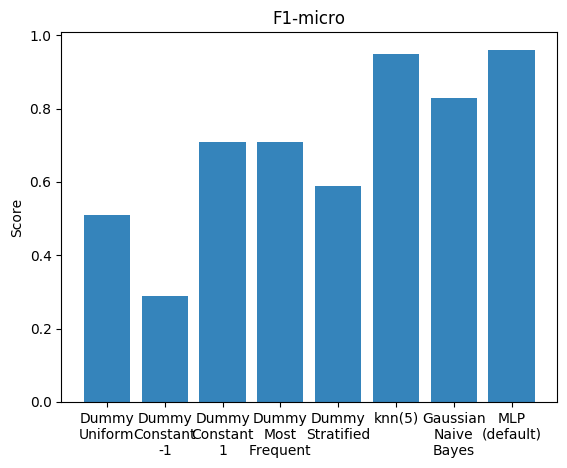

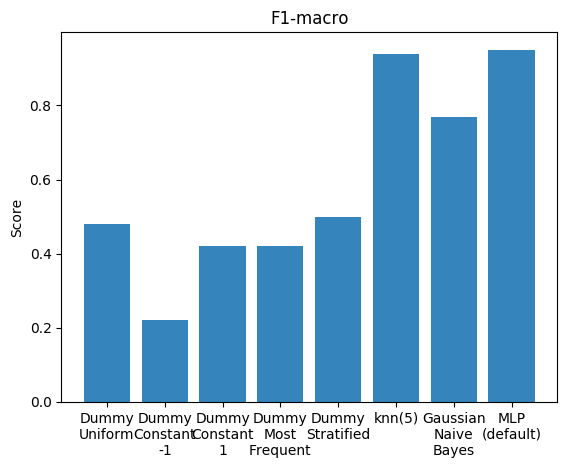

In [0]:
classifiers = ('Dummy\nUniform', 'Dummy\nConstant\n-1', 'Dummy\nConstant\n1', 'Dummy\nMost\nFrequent', 'Dummy\nStratified', 'knn(5)','Gaussian\nNaive\nBayes','MLP\n(default)')
classifiers_f1_micro = [0.51, 0.29, 0.71, 0.71, 0.59, 0.95, 0.83, 0.96]
classifiers_f1_macro = [0.48, 0.22, 0.42, 0.42, 0.50, 0.94, 0.77, 0.95]
plot_bar(classifiers, classifiers_f1_micro, "F1-micro")
plot_bar(classifiers, classifiers_f1_macro, "F1-macro")

#### **Σχολιασμός αποτελεσμάτων default ταξινομητών**

Παρατηρούμε ότι ο MLP δίνει τα καλύτερα αποτελέσματα από όλους τους παραπάνω ταξινομητές, με τον knn να είναι πολύ κοντά του και για τα δυο f1 scores, γεγονός που ίσως μας εκπλήσει, καθώς ο knn φαίνεται αρκετά πιο απλός. Το γεγονός ότι ο knn είναι τόσο κοντά με τον MLP, ο οποίος είναι και σε πάρα πολύ υψηλά scores, σημαίνει ότι περιμένουμε μάλλον μικρή βελτιστοποίηση και από τους δυο. Επιπλέον τα μεγάλα scores από τον knn(5) δείχνουν ότι το μοντέλο δουλεύει πολύ καλά με σχετικά high variance, καθώς επίσης και ότι υπάρχουν πολλά γειτονικά δείγματα ίδιου label. Επιπλέον, παρατηρούμε ότι ο gnb απέχει παρά πολύ από τα dummies, που έχουν ποσοστά πολύ χαμηλά λόγω της τυχαιότητας κατά την πρόβλεψή τους. Ωστόσο, όπως είπαμε και παραπάνω είναι δεδομένο ότι δέχεται ικανοποιητική βελτίωση σε όλες τις μετρικές. 

### **(Δ) Βελτιστοποίηση ταξινομητών**

####Regularization

Αρχικά ελέγχουμε αν τα δεδομένα μας είναι ήδη κανονικοποιημένα (regularized)

In [0]:
checkScaled(X_train)
checkScaled(X_test)

Regularized
Regularized


Παρατηρούμε ότι είναι ήδη κανονικοποιημένα οπότε δεν χρειάζεται να το κάνουμε εμεις

Θα ακολουθήσουμε δυο τεχνικές: 
- PCA-Undersampling-GridSearch-cv
- Pipeline, Gridsearch-cv-Undersamping-PCA  

Για χάριν μελέτης, ακολουθούμε την πρώτη τεχνική χωρίς την χρήση sklearn pipelines. Πρώτα, κάνουμε το PCA, μετά το undersampling και στο τέλος το gridsearch για την αναζήτηση των βέλτιστων υπερπαραμέτρων των ταξινομητών που εξετάζουμε. Αξίζει να σημειωθεί ότι εδώ το undersampling δεν κάνει θεωρητικά κακό που είναι έξω από το gridsearch, όπως το oversampling που είδαμε στο small dataset, γιατί δεν προσθέτει duplicates στο cv, απλώς αφαιρεί samples.  
Στην δεύτερη τεχνική, θα ακολουθήσουμε το κλασικό μοντέλο pipeline της sklearn βιβλιοθήκης, που προσφέρει αρκετές βελτιστοποιήσεις και παράγει αναλυτικά αποτελέσματα της εκτέλεσης, μέσα στο οποίο γίνονται οι όποιοι μετασχηματισμοί (variance threshold, sampling, PCA).


#### PCA

Αρχικά υπολογίζουμε τον πίνακα συσχέτισης (covariance matrix) των μεταβλητών που έχουμε στα δεδομένα. Από αυτόν τον πίνακα βρίσκουμε τις γραμμικώς συσχετισμένες μεταβλητές και βρίσκοντας τα ιδιοδιανύσματα του πίνακα μπορούμε να μετατρέψουμε τον πίνακα με έναν ορθογώνιο μετασχηματισμό και να βρούμε την βάση του νέου πίνακα. Αυτή η βάση του χώρου αποτελεί ένα νέο σύνολο μεταβλητών που είναι γραμμικά ασυσχέτιστες και ονομάζονται κύριες συνιστώσες.

Στο σημείο αυτό, θα χρησιμοποιήσουμε αρκετές διαφορετικές εκδοχές του PCA, δημιουργώντας έτσι διαφορετικά datasets, με n_components από το 10 εώς το 131 με βήμα 10 για κάθε dataset. Έτσι, θα μελετήσουμε τελικά 14 διαφορετικά datasets, προερχόμενα από διαφορετικό PCA, και το αρχικό που δεν έχει υποστεί PCA.

In [0]:
from sklearn.decomposition import PCA

def applyPCA(X_train, X_test, n):
  # Returns a tuple (X_train_pca, X_test_pca)
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)
  return (X_train_pca, X_test_pca, n)

In [0]:
# A list[...] of tuples: (X_train_pca, X_test_pca, n)
dataPCA = []
k = 10
# Apply PCA for the first (n_features-1) even integers
for n in range(n_features+1):
  if (n == 0):
    continue
  if (n == n_features):
    # No PCA
    dataPCA.append((X_train, X_test, n))
    break
  if (n % k == 0):
    dataPCA.append(applyPCA(X_train, X_test, n))

initial_data_PCA = dataPCA.copy()

####Undersampling

Στο Random undersampling, δείγματα της πλειοψηφίας με τυχαίο τρόπο επιλέγονται και αφαιρούνται, μέχρι η ισορροπία του dataset φθάσει στα επιθυμητά επιπέδα ισορροπίας. Η μέθοδος αυτή έχει το κακό ότι με την αφαίρεση samples ενδέχεται να χαθεί πολύτιμη πληροφορία και να αυξηθεί το variance του ταξινομητή, με αποτέλεσμα να προτιμάται μόνο για μεγάλα datasets, όπου είναι αρκετά χρονοβόρες οι διαδικασίες του gridsearch, όπως στην περίπτωσή μας για μεγάλο parameter grid ορισμένων ταξινομητών.

In [0]:
from imblearn.under_sampling import RandomUnderSampler

# Random Undersampling
def random_undersampling(X_train_pca, y_train, ratio=0.75):
  ru = RandomUnderSampler(sampling_strategy=ratio, random_state=32)
  # Undersampling
  X__train_resampled, y_train_resampled = ru.fit_resample(X_train_pca, y_train)

  return (X__train_resampled, y_train_resampled)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Apply undersampling on the scaled-PCA-transformed training sets
y_train_sampled = []
for i in range(0, len(initial_data_PCA)):
  (X_over, y_sampled_tmp) = random_undersampling(initial_data_PCA[i][0], 
                                                 y_train, ratio=0.65)
  y_train_sampled.append(y_sampled_tmp)
  dataPCA[i] = (X_over, initial_data_PCA[i][1], initial_data_PCA[i][2]) # sklearn gridsearchcv

#### Plot

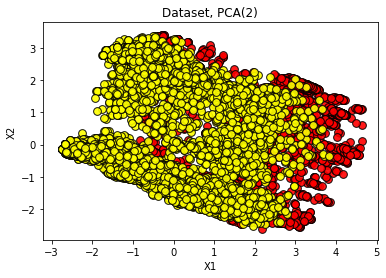

In [0]:
import matplotlib.pyplot as plt ; plt.rcdefaults()
import numpy as np
# Plot training set for PCA(n_components=2) and oversampling SMOTE(ratio=0.6)
X0, X1 = dataPCA[0][0][:,0], dataPCA[0][0][:,1]
colors = {}
colors[-1] = 'red'
colors[1] = 'yellow'
fig, ax = plt.subplots()
for label in [-1,1]:
    ax.scatter(
        X0[y_train_sampled[0] == label], X1[y_train_sampled[0] == label],
        c=(colors[int(label)]), label=int(label),
        s=60, alpha=0.9, edgecolors="k"
    )
    
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Dataset, PCA(2)')
plt.show()

####**Dummy Stratified**

Μεταξύ των dummy ταξινομητών, η καλύτερη στρατηγική είναι να διαλέγουμε πάντοτε την πιο συχνή κλάση (ή ισοδύναμα σταθερά την κλάση που είναι η πιο συχνή).
Εαν δοκιμάσουμε πολλά runs, θα παρατηρήσουμε ότι η επιλογή stratified, δηλαδή να επιλέγουμε τυχαία κλάση διατηρώντας την κατανομή των κλάσεων στο training set, είναι τόσο πιο συχνά καλύτερη από την τυχαία (uniform) επιλογή, όσο περισσότερο μη ισορροπημένες είναι οι συχνότητες των κλάσεων στο dataset.

Τα δεδομένα του συγκεκριμένου dataset είναι αρκετά μη ισορροπημένα. Για τον λόγο αυτό παρακάτω γίνεται μια προσπάθεια βελτιστοποίησης του Stratified Dummy Classifier. Η βελτιστοποίηση έγκειται στην αλλαγή της τιμής του sampling_strategy για το undersampling που κάνουμε στα δείγματα. Έτσι, διαλέγεται η τιμή του undersampling sampling_strategy που δίνει το καλύτερο f1 score. 

In [10]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier

rus = RandomUnderSampler()
clf = DummyClassifier(strategy="stratified")
pipe = Pipeline(steps=[('sampler', rus), ('dummy', clf)])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


**F1-MICRO**

In [0]:
from sklearn.model_selection import GridSearchCV
sampling_strategy=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

pipe = Pipeline(steps=[('sampler', rus), ('dummy', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy = sampling_strategy), 
                         cv=5, scoring='f1_micro', n_jobs=-1)

In [12]:
import time 
print("X_train shape: \t", X_train.shape)
print("y_train shape: \t", y_train.shape)
start_time = time.time() 
estimator.fit(X_train, y_train) 
y_pred = estimator.predict(X_test) 

X_train shape: 	 (24125, 131)
y_train shape: 	 (24125,)


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
print("Dummy GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time)) 
print(classification_report(y_test, y_pred)) 
print(estimator.best_estimator_) 
print(estimator.best_params_)

Dummy GridSearch Overall time for fit και predict: 9.966006517410278 seconds
              precision    recall  f1-score   support

          -1       0.27      0.32      0.29      2907
           1       0.71      0.66      0.68      7433

    accuracy                           0.56     10340
   macro avg       0.49      0.49      0.49     10340
weighted avg       0.59      0.56      0.57     10340

Pipeline(memory='tmp',
         steps=[('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.5)),
                ('dummy',
                 DummyClassifier(constant=None, random_state=None,
                                 strategy='stratified'))],
         verbose=False)
{'sampler__sampling_strategy': 0.5}


**F1-MACRO**

In [0]:
from sklearn.model_selection import GridSearchCV
sampling_strategy=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

pipe = Pipeline(steps=[('sampler', rus), ('dummy', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(sampler__sampling_strategy = sampling_strategy), 
                         cv=5, scoring='f1_macro', n_jobs=-1)


In [15]:
import time 
print("X_train shape: \t", X_train.shape)
print("y_train shape: \t", y_train.shape)
start_time = time.time() 
estimator.fit(X_train, y_train) 
y_pred = estimator.predict(X_test) 

X_train shape: 	 (24125, 131)
y_train shape: 	 (24125,)


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
print("Dummy GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time)) 
print(classification_report(y_test, y_pred)) 
print(estimator.best_estimator_) 
print(estimator.best_params_)

Dummy GridSearch Overall time for fit και predict: 7.497633695602417 seconds
              precision    recall  f1-score   support

          -1       0.28      0.33      0.31      2907
           1       0.72      0.67      0.69      7433

    accuracy                           0.58     10340
   macro avg       0.50      0.50      0.50     10340
weighted avg       0.60      0.58      0.59     10340

Pipeline(memory='tmp',
         steps=[('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.5)),
                ('dummy',
                 DummyClassifier(constant=None, random_state=None,
                                 strategy='stratified'))],
         verbose=False)
{'sampler__sampling_strategy': 0.5}


Βλέπουμε ότι το undersampling δεν βελτιώνει την απόδοση του stratified dummy classifier, γεγονός που εξηγείται στο ότι γίνεται εξισορρόπηση στο training set, με το test set να έχει ακόμα ανισόρροπες αναλογίες για τις δυο κλάσεις. Όμως, δεδομένου του 29%-71% της ισορροπίας τόσο του trainset και του testset, η σταθερή βελτιστοποίηση του stratified θα ήταν εάν έτεινε στον constant-1. Έτσι, αν ρίχναμε samples από την μειοψηφία των κλάσεων, τότε θα έδινε μάλλον καλύτερα αποτελέσματα, και στην ακραία περίπτωση που τα ρίχναμε όλα εκτός από ένα (ένα διότι πρέπει υποχρεωτικά να υπάρχουν αντιπρόσωπα δείγματα από όλες τις κλάσεις), τότε θα έτεινε ακόμα πιο πολύ στον constant-1 και το score θα ήταν περίπου ίσο με το ποσοστό της πλειοψηφίας, δηλαδή της κλάσης merged. Αυτή θα ήταν μια σταθερή βελτιστοποιήση του stratified dummy classifier.

#### **k-nearest neighbors classifier (knn)**

Το k της γειτονιάς του kNN είναι μια υπερπαράμετρος του ταξινομητή. Μια άλλη υπερπαράμετρος είναι η συνάρτηση της απόστασης και μια άλλη η συνάρτηση του βάρους που χρησιμοποιείται για την πρόβλεψη. Οι υπερπαράμετροι είναι επιλογές που γίνονται από τον σχεδιαστή του συστήματος και δεν μπορούμε να ξέρουμε τις βέλτιστες τιμές τους αν πρώτα δεν τις αξιολογήσουμε εμπειρικά σε δεδομένα. Παρακάτω γίνεται αναζήτηση των βέλτιστων τιμών των υπερπαραμέτρων k, weights, metric του knn με χρήση GridSearchCV με δύο διαφορετικούς τρόπους

**1ος Τροπος**

Έξω από το gridsearchcv, κάνουμε PCA στα δεδομένα για διάφορες τιμές του PCA και τα κρατάμε σε μια λίστα. Έπειτα τα περνάμε σε συνάρτηση undersampling, καθώς το πλήθος των δειγμάτων είναι πολύ μεγάλο και προσπαθούμε να τα εξισορροπήσουμε σε έναν βαθμό χωρίς όμως να διαγράψουμε πολλά δείγματα. Επιλέχθηκε για το undersampling sampling_strategy=0.7 για αυτο το λόγο, καθώς επίσης δοκιμάστικαν και άλλα ratio αλλά δεν ήταν τόσο αποτελεσματικά όσο αυτό.
Παρατίθενται δύο πανομοιότυπες κλήσεις της gridsearchcv , μία με στρατηγική scoring="accuracy" και μια με scoring="f1_macro". Τυπώνονται όλα τα ενδιάμεσα αποτελέσματα για καλύτερη εποπτεία της απόδοσης συναρτήση των δεδομένων. 
Στο τέλος ωστόσο τυπώνεται μόνο ο καλύτερος knn classifier που βρήκαμε με τις παραμέτρους του και το score του στο gridsearchcv, για τον οποίο και μόνο γίνεται το predict και το τύπωμα του τελικού αποτελέσματος.

**F1-MICRO**

In [0]:
from sklearn.model_selection import GridSearchCV
import time
# Run all initial_data_PCA for each grid parameter of MLP
knn_best_score_micro = 0
optimal_knn_micro = None

knn_params_grid = {"n_neighbors":[i for i in range(1,18,2)],
                     "weights": ['uniform','distance'],
                     "metric":['euclidean','manhattan','minkowski']}

print(dataPCA[0][0].shape)
start_time = time.time()
for i in range(0, len(dataPCA)):
  data_tmp = dataPCA[i]
  knn = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params_grid, scoring="accuracy",
                                  cv=5, n_jobs=-1)
  knn.fit(data_tmp[0], y_train_sampled[i])

  # F1-micro
  best_score = np.max(knn.cv_results_['mean_test_score'])
  if (best_score > knn_best_score_micro):
    knn_best_score_micro = best_score
    optimal_knn_micro = knn
    features = data_tmp[2]
  
  print("n_features: " + str(data_tmp[2]))
  print(str(knn.best_params_) + "\t" + str(np.max(knn.cv_results_['mean_test_score'])))
  print(knn.cv_results_['mean_test_score'])

#Total time 
print("Total GridSearch time: %s seconds" % (time.time() - start_time)) 

(17540, 10)
n_features: 10
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}	0.9405929304446978
[0.93232611 0.93232611 0.93523375 0.93779932 0.93580388 0.94047891
 0.93323831 0.94013683 0.93175599 0.93985177 0.9309008  0.93985177
 0.9295325  0.93928164 0.9286203  0.93876853 0.92651083 0.93745724
 0.93255416 0.93255416 0.93489168 0.93762828 0.93568985 0.94059293
 0.93295325 0.93979475 0.93221209 0.94036488 0.92976055 0.93882554
 0.92839225 0.93825542 0.92742303 0.93785633 0.92571266 0.9368301
 0.93232611 0.93232611 0.93523375 0.93779932 0.93580388 0.94047891
 0.93323831 0.94013683 0.93175599 0.93985177 0.9309008  0.93985177
 0.9295325  0.93928164 0.9286203  0.93876853 0.92651083 0.93745724]
n_features: 20
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}	0.9442417331812999
[0.93551881 0.93551881 0.93734322 0.94013683 0.93797035 0.94310148
 0.93614595 0.94264538 0.93397948 0.94281642 0.93329532 0.94190422
 0.9327252  0.94253136 0.93118586 0.94156214 0.93187

*F1-MICRO CV RESULTS*

In [0]:
print("Total GridSearch time: %s seconds" % (time.time() - start_time)) 

Total GridSearch time: 5158.368354797363 seconds


In [0]:
print("Optimal knn classifier:\t", optimal_knn_micro, 
      "\nwith PCA Components =", features,
      "\nand F1-micro accuracy score for cv: \t", knn_best_score_micro)
#print(str(knn.best_params_) + "\t" + str(np.max(knn.cv_results_['mean_test_score'])))

Optimal knn classifier:	 GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0) 
with PCA Components = 131 
and F1-micro accuracy score for cv: 	 0.9484036488027366


*F1-MICRO CLASSIFICATION REPORT*

In [0]:
from sklearn.metrics import classification_report

# PCA(features) --> dataPCA[features] --> dataPCA[(features/2)-1]
if(features == 131):
  features = 13
else:
  features = int(features/10)-1
y_pred = optimal_knn_micro.predict(dataPCA[features][1])
# print(y_pred)
# print(y_test)
print(classification_report(y_test, y_pred))
print("Testset F1-micro accuracy score: \t", precision_recall_fscore_support(y_test, y_pred, average='micro')[2])
print()

# # No PCA
# knn_no_pca = KNeighborsClassifier(n_neighbors=optimal_classifier.optimal_clf.n_neighbors)
# knn_no_pca.fit(dataPCA[30][0], y_train)
# y_pred = knn_no_pca.predict(dataPCA[30][1])
# print("Testset F1-micro accuracy score (No PCA, Oversampling): ", precision_recall_fscore_support(y_test, 
#                                                                                                   y_pred, average='micro')[2])

# # No preprocessing / default k=5
# knn_no_pca = KNeighborsClassifier(n_neighbors=5)
# knn_no_pca.fit(X_train, y_train)
# y_pred = knn_no_pca.predict(X_test)
# print("Testset F1-micro accuracy score (No Preprocessing): \t",  precision_recall_fscore_support(y_test, 
#                                                                                                   y_pred, average='micro')[2])

              precision    recall  f1-score   support

          -1       0.89      0.95      0.91      2934
           1       0.98      0.95      0.96      7406

    accuracy                           0.95     10340
   macro avg       0.93      0.95      0.94     10340
weighted avg       0.95      0.95      0.95     10340

Testset F1-micro accuracy score: 	 0.9498065764023211



**F1-MACRO**

In [0]:
from sklearn.model_selection import GridSearchCV
import time
# Run all initial_data_PCA for each grid parameter of MLP
knn_best_score_macro = 0
optimal_knn_macro = None

knn_params_grid = {"n_neighbors":[i for i in range(1,18,2)],
                     "weights": ['uniform','distance'],
                     "metric":['euclidean','manhattan','minkowski']}

print(dataPCA[0][0].shape)
start_time = time.time()
for i in range(0, len(dataPCA)):
  data_tmp = dataPCA[i]
  knn = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params_grid, scoring="f1_macro",
                                  cv=5, n_jobs=-1)
  knn.fit(data_tmp[0], y_train_sampled[i])

  # F1-macro
  best_score = np.max(knn.cv_results_['mean_test_score'])
  if (best_score > knn_best_score_macro):
    knn_best_score_macro = best_score
    optimal_knn_macro = knn
    features = data_tmp[2]
  
  print("n_features: " + str(data_tmp[2]))
  print(str(knn.best_params_) + "\t" + str(np.max(knn.cv_results_['mean_test_score'])))
  print(knn.cv_results_['mean_test_score'])

#Total time 
print("Total GridSearch time: %s seconds" % (time.time() - start_time)) 

(17540, 10)
n_features: 10
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}	0.9379210003496341
[0.92921544 0.92921544 0.93226052 0.934915   0.93295504 0.93779949
 0.93029631 0.93747287 0.92873482 0.93718554 0.92792593 0.93721379
 0.9264984  0.93662581 0.92558184 0.93610833 0.92344216 0.93476338
 0.92944931 0.92944931 0.9319561  0.93478399 0.93286652 0.937921
 0.93004598 0.93712896 0.92926791 0.93775212 0.92680361 0.93617979
 0.92537181 0.93561327 0.9244265  0.93522254 0.9226814  0.93416819
 0.92921544 0.92921544 0.93226052 0.934915   0.93295504 0.93779949
 0.93029631 0.93747287 0.92873482 0.93718554 0.92792593 0.93721379
 0.9264984  0.93662581 0.92558184 0.93610833 0.92344216 0.93476338]
n_features: 20
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}	0.9418965604029819
[0.93254095 0.93254095 0.93455687 0.93746952 0.9352567  0.94058947
 0.93341468 0.94014032 0.93117187 0.94032572 0.93053763 0.93939595
 0.92999882 0.94007921 0.92843527 0.93909458 0.929163

*F1-MACRO CV RESULTS*

In [0]:
print("Total GridSearch time: %s seconds" % (time.time() - start_time))
print("Optimal knn classifier:\t", optimal_knn_macro, 
      "\nwith PCA Components =", features,
      "\nand F1-macro accuracy score for cv: \t", knn_best_score_macro)

Total GridSearch time: 5239.718576669693 seconds
Optimal knn classifier:	 GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=0) 
with PCA Components = 131 
and F1-macro accuracy score for cv: 	 0.9461545697490779


*F1-MACRO CLASSIFICATION REPORT*

In [0]:
from sklearn.metrics import classification_report

# PCA(features) --> dataPCA[features] --> dataPCA[(features/2)-1]
if(features == 131):
  features = 13
else:
  features = int(features/10)-1
y_pred = optimal_knn_macro.predict(dataPCA[features][1])
# print(y_pred)
# print(y_test)
print(classification_report(y_test, y_pred))
print("Testset F1-macro accuracy score: \t", precision_recall_fscore_support(y_test, y_pred, average='macro')[2])
print()

              precision    recall  f1-score   support

          -1       0.89      0.95      0.91      2934
           1       0.98      0.95      0.96      7406

    accuracy                           0.95     10340
   macro avg       0.93      0.95      0.94     10340
weighted avg       0.95      0.95      0.95     10340

Testset F1-macro accuracy score: 	 0.9394811288822034



Παρατηρούμε πως το recall των δύο κλάσεων εξισορροπήθηκε. Όπως ήταν αναμενόμενο το recall της κλάσης της πρώτης(-1) αυξήθηκε αρκετά από 0.91 σε 0.95 και για το σκοπό αυτό υπήρξε μια μικρή μείωση στο recall της δεύτερης κλάσης(1).
Αυξάνωντας το recall της πρώτης κλάσης όμως το μοντέλο αύξησε την πρόβλεψη του σε -1 και μείωσε την προβλεψή του σε 1. Αυτό είχε ως αποτέλεσμα μικρή αύξηση του precision του 1 και μικρή μείωση του precision του -1,  πετυχαίμοντας, έτσι, τον αρχικό μας στόχο, ακόμα και χωρίς τη χρήση pipeline.

Όπως φαίνεται από τα τρεξίματα, πετύχαμε μια μικρή βελτίωση στο τελικό αποτέλεσμα. Αυτό συνέβη καθώς το τρέξιμο μας έβγαλε ως βέλτιστες υπερπαραμέτους $k=5$, metric='minkowski', weights = 'uniform' που με εξαίρεση την $k=5$ θεωρούνται και οι default τιμές του knn. Το PCA φαίνεται να μην είναι τόσο χρήσιμο για το συγκεκριμένο dataset καθώς και στις δύο μετρικές επιλέχθηκε ως βέλτιστο αποτέλεσμα για το crossvalidation του gridsearchcv το pca_components=131 όσα δηλαδή και τα ολικά μας δείγματα.

**2ος Τροπος**

Εδώ θα γίνει χρήση του gridsearchcv από την sklearn όπως και πριν, αλλά αυτή τη φορά τα βήματα που θα κάνει και η παραμέτρους που θα δοκιμάσει θα δοθούν μέσα σε ένα pipeline. Δοκιμάζονται διάφορα τρεξίματα με διαφορετικές τιμές για το PCA για να βρεθούν τα καλύτερα δυνατά αποτελέσματα.
Όπως προαναφέρθηκε, για την κατασκευή του μοντέλου θα βασιστούμε στην κλάση Pipeline. Επειδή οι κλάσεις εξισορρόπησης του imblearn όπως η RandomOverSampler τυπικά δεν έχουν μέθοδο transform (έχουν fit_sample) η built-in Pipeline του scikit (from sklearn.pipeline import Pipeline) δεν τις δέχεται ως transformers. Θα φέρουμε την Pipeline από το imblearn (που έχει transform για τους samplers).

Στα πρώτα κελιά κάνουμε τα απαραίτητα import , μελετάμε το variance των μεταβλητών για το variance threshold και θέτουμε τις τιμές ορισμού για τις υπερπαραμέτρους.

In [0]:
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρείς παραμέτρους
selector = VarianceThreshold()
rus = RandomUnderSampler(0.7)
pca = PCA()
clf = KNeighborsClassifier(n_jobs=-1) # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('knn', clf)])

In [0]:
train_variance = X_train.var(axis=0)
print(np.sort(train_variance))
print(np.max(train_variance))

[8.28946817e-05 8.28946817e-05 1.24336706e-04 1.24336706e-04
 1.24336706e-04 1.24336706e-04 1.24336706e-04 1.24336706e-04
 1.24336868e-04 1.24336868e-04 2.07210932e-04 2.07210932e-04
 1.77920653e-03 1.77920653e-03 2.93593395e-03 4.68416931e-03
 7.12351651e-03 1.21997515e-02 1.30075992e-02 1.56236115e-02
 1.56236115e-02 1.65908274e-02 1.79964752e-02 2.48817100e-02
 2.49603711e-02 2.58639860e-02 2.66359571e-02 2.71048653e-02
 2.91876597e-02 3.03936445e-02 3.21339848e-02 3.45693468e-02
 3.70032332e-02 3.70833916e-02 3.71493195e-02 3.72450185e-02
 3.73809636e-02 3.84762626e-02 3.84762626e-02 3.85906306e-02
 3.85906306e-02 4.13998455e-02 4.14464779e-02 4.30033575e-02
 4.32907862e-02 4.32907862e-02 4.36107220e-02 4.38181295e-02
 4.39310439e-02 4.56210501e-02 4.77517352e-02 4.94630947e-02
 5.10756295e-02 5.45918046e-02 5.46656798e-02 5.48147811e-02
 5.51029124e-02 5.52860950e-02 5.76927570e-02 5.76927570e-02
 5.78744875e-02 5.80924507e-02 5.97232317e-02 6.40989938e-02
 6.44971428e-02 6.453589

In [0]:
from sklearn.model_selection import GridSearchCV

vthreshold = [0.001, 0.01, 0.1] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
n_components = [10, 20, 30, 40, 50]
k = [1, 3, 5, 7, 9, 11, 13, 15, 17] 
weights = ['distance', 'uniform']
metric = ['euclidean', 'manhattan', 'minkowski']

Επειδή ο χώρος αναζήτησης των βέλτιστων υπερπαραμέτρων είναι μεγάλος, ξαναορίζουμε την pipeline με την παράμετρο 'memory': για κάθε fold του crossvalidation και για καθε συνδυασμό υπερπαραμέτρων μετασχηματιστών, τα δεδομένα χρειάζεται να μετασχηματιστούν μία φορά και όχι για κάθε νέα τιμή υπερπαραμέτρων του εκτιμητή.
Από εδώ και κάτω τρέχουμε με διαφορετικές τιμές και δυνατότητες PCA για F1-MICRO και F1-MACRO

#####**F1-micro**

######F1-micro with pca__n_compontents=[10,20,30,40,50]

In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_micro', n_jobs=-1)



In [0]:
import time
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("Knn GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))

Knn GridSearch Overall time for fit και predict: 2887.018813610077 seconds
              precision    recall  f1-score   support

          -1       0.87      0.94      0.91      3017
           1       0.98      0.94      0.96      7323

    accuracy                           0.94     10340
   macro avg       0.92      0.94      0.93     10340
weighted avg       0.95      0.94      0.94     10340



In [0]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.001)),
                ('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.7)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=-1, n_neighbors=5, p=2,
                                      weights='distance'))],
         verbose=False)
{'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'pca__n_components': 50, 'selector__threshold': 0.001}


######F1-micro without PCA

In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_micro', n_jobs=-1)



In [0]:
import time
print("X_train shape: \t", X_train.shape)
print("y_train shape: \t", y_train.shape)
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("Knn GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))

X_train shape: 	 (24125, 131)
y_train shape: 	 (24125,)
Knn GridSearch Overall time for fit και predict: 2412.790825843811 seconds
              precision    recall  f1-score   support

          -1       0.88      0.94      0.91      2963
           1       0.98      0.95      0.96      7377

    accuracy                           0.95     10340
   macro avg       0.93      0.95      0.94     10340
weighted avg       0.95      0.95      0.95     10340



In [0]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.01)),
                ('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.7)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=-1, n_neighbors=3, p=2,
                                      weights='distance'))],
         verbose=False)
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance', 'selector__threshold': 0.01}


######F1-micro with default PCA (no components given)



In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_micro', n_jobs=-1)



In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_micro', n_jobs=-1)



In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold,  
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_micro', n_jobs=-1)

In [0]:
import time
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("Knn GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))
print(estimator.best_estimator_)
print(estimator.best_params_)

Knn GridSearch Overall time for fit και predict: 1789.9830000400543 seconds
              precision    recall  f1-score   support

          -1       0.88      0.94      0.91      2963
           1       0.98      0.95      0.96      7377

    accuracy                           0.95     10340
   macro avg       0.93      0.94      0.93     10340
weighted avg       0.95      0.95      0.95     10340

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.01)),
                ('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.7)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='

######**ΣΧΟΛΙΑΣΜΟΣ ΑΠΟΤΕΛΕΣΜΑΤΩΝ**

Όπως παρατηρούμε, το PCA δεν βοήθησε ούτε με αυτό τον τρόπο στη βελτίωση του αποτελέσματος καθώς με χρήση PCA το βέλτιστο βγαίνει 0.94 ενώ χωρίς χρήση PCA ή με χρήση default PCA (χωρίς να του δίνουμε χειροκίνητα τα components αλλά να βρίσκει μόνο του τα μέγιστα ασυσχέτιστα δείγματα) το αποτέλεσμα είναι 0.95.
Αξίζει να σημειωθεί πως το καλύτερο αποτέλεσμα βγαίνει για $k=3$ , weights=distance και metric=manhattan. Αυτό σημαίνει πως οι default τιμές του knn δεν ήταν οι βέλτιστες και πως εδώ έχουμε βελτίωση. Ωστόσο, επειδή είναι μικρή δεν παρατηρείται με δύο δεκαδικά ψηφία και το αποτέλεσμα στρογγυλοποιείται στο 0.95. Έτσι, το μοντέλο μας χρειάζεται ακόμα πιο high variance από το default, και για αυτό το λόγο επιλέγεται $k<5$.


##### **F1-macro**

Στην F1-macro στρατηγική, δε θα δοθούν default τιμές PCA όπως στην F1-micro αφού φαίνεται από όλα τα τρεξίματα πως δεν δίνουν καλύτερο αποτέλεσμα. Εκτός αυτού, δεδομένου ότι και στην F1-micro και στην F1-macro χρησιμοποιούμε variance threshold, μας περιορίζει ως προς την ελευθερία του να διαλέξουμε εμείς συνιστώσες PCA. Έτσι ακολουθούν δύο διαφορετικά τρεξίματα ένα χωρίς PCA και ένα ελεύθερο PCA. 

######F1-macro without PCA

In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_macro', n_jobs=-1)

In [0]:
import time
print("X_train shape: \t", X_train.shape)
print("y_train shape: \t", y_train.shape)
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)


X_train shape: 	 (24125, 131)
y_train shape: 	 (24125,)


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
print("Knn GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))
print(estimator.best_estimator_) 
print(estimator.best_params_)

Knn GridSearch Overall time for fit και predict: 2692.7798838615417 seconds
              precision    recall  f1-score   support

          -1       0.89      0.94      0.91      2936
           1       0.97      0.95      0.96      7404

    accuracy                           0.95     10340
   macro avg       0.93      0.95      0.94     10340
weighted avg       0.95      0.95      0.95     10340

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.001)),
                ('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.7)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=-1, n_neighbors=3, p=2,
                                  

######F1-macro with default PCA (no components given)

In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('knn', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold,  
                                    knn__n_neighbors=k, knn__weights=weights, knn__metric=metric), 
                         cv=5, scoring='f1_macro', n_jobs=-1)

In [0]:
import time 
print("X_train shape: \t", X_train.shape)
print("y_train shape: \t", y_train.shape)
start_time = time.time() 
estimator.fit(X_train, y_train) 
y_pred = estimator.predict(X_test) 

X_train shape: 	 (24125, 131)
y_train shape: 	 (24125,)


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
print("Knn GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time)) 
print(classification_report(y_test, y_pred)) 
print(estimator.best_estimator_) 
print(estimator.best_params_)

Knn GridSearch Overall time for fit και predict: 1985.897340297699 seconds
              precision    recall  f1-score   support

          -1       0.89      0.94      0.91      2936
           1       0.97      0.95      0.96      7404

    accuracy                           0.95     10340
   macro avg       0.93      0.94      0.94     10340
weighted avg       0.95      0.95      0.95     10340

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.001)),
                ('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.7)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='

######**ΣΧΟΛΙΑΣΜΌΣ ΑΠΟΤΕΛΕΣΜΆΤΩΝ**

Όπως και στην f1-micro το καλύτερο αποτέλεσμα έχει k=3, weigts=distance και metric=manhattan. Το αποτέλεσμα στογγυλοποιείται στο 0.94 που είναι μια βελτίωση του 0.937 του αρχικού. Η μόνη διαφορά με την F1-micro είναι πως εδώ επιλέχθηκε για threshold 0.001 η μικρότερη δυνατή τιμή από τις δοθείσες παραμέτρους.  



Έτσι, βλέπουμε ότι από όλες τις τεχνικές που χρησιμοποιήθηκαν, τα καλύτερα recall και precision scores τα είχε η πρώτη μέθοδος χωρίς το pipeline, η οποία κατάφερε να εξισορροπήσει κυρίως το recall, και άρα να καθιστά το μοντέλο ελάχιστα πιο ευέλικτο. 

#### **Multi-Layer Perceptron (MLP)** 

##### **F1-micro**

Ακολουθούμε στην αρχή την πρώτη τεχνική που περιγράφηκε παραπάνω για εύρεση του καλύτερου ταξινομητή με βάση το f1_micro. Χρησιμοποιούμε ένα parameter grid που περιέχει πάρα πολλούς συνδυασμούς MLP classifiers και κάνουμε gridsearch χωρίς pipeline.

In [0]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

# Run all initial_data_PCA for each grid parameter of MLP
from sklearn.neural_network import MLPClassifier
mlp_best_score_micro = 0
optimal_mlp_micro = None

mlp_params_grid = [{"hidden_layer_sizes": [(100,), 
                                           (200,)],
                     "activation": ['tanh', 'relu'],
                     "solver": ['lbfgs', 'sgd'], 
                     "max_iter": [150], "alpha": [0.0001, 0.05], 
                     "learning_rate": ['constant','adaptive']}]

import time
start_time = time.time()
# No undersampling
for i in range(0, len(initial_data_PCA)):
  data_tmp = initial_data_PCA[i]
  mlp = GridSearchCV(MLPClassifier(), param_grid=mlp_params_grid, n_jobs=-1, scoring='accuracy')

  mlp.fit(data_tmp[0], y_train)
  print("PCA components:\t", data_tmp[2])
 
  best_score = np.max(mlp.cv_results_['mean_test_score'])
  if (best_score > mlp_best_score_micro):
    mlp_best_score_micro = best_score
    optimal_mlp_micro = mlp
    features = data_tmp[2]

print("GridSearch overall time: %s seconds" % (time.time() - start_time))

PCA components:	 10
PCA components:	 20
PCA components:	 30
PCA components:	 40
PCA components:	 50
PCA components:	 60
PCA components:	 70
PCA components:	 80
PCA components:	 90
PCA components:	 100
PCA components:	 110
PCA components:	 120
PCA components:	 130
PCA components:	 131
GridSearch overall time: 15357.295123815536 seconds


In [0]:
print("Optimal knn classifier:\t", optimal_mlp_micro, 
      "\nwith PCA Components =", features,
      "\nand F1-micro accuracy score for cv: \t", mlp_best_score_micro)

Optimal knn classifier:	 GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'activation': ['tanh', 'relu'],
                          'alpha': [0.0001, 0.05],
                 

In [0]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from warnings import filterwarnings
filterwarnings('ignore')

if(features == 131):
  features = 13
else:
  features = int(features/10)-1
y_pred = optimal_mlp_micro.predict(dataPCA[features][1])
# print(y_pred)
# print(y_test)
print(classification_report(y_test, y_pred))
print("Testset F1-micro accuracy score: \t", precision_recall_fscore_support(y_test, y_pred, average='micro')[2])
print()

              precision    recall  f1-score   support

          -1       0.93      0.94      0.93      2950
           1       0.97      0.97      0.97      7390

    accuracy                           0.96     10340
   macro avg       0.95      0.95      0.95     10340
weighted avg       0.96      0.96      0.96     10340

Testset F1-micro accuracy score: 	 0.9615087040618956



Παρατηρούμε ότι βελτιώνεται το f1_micro κατά 0.2% περίπου με χρήση αυτής της τεχνικής, καθώς και το precision των not merged, ενώ οι υπόλοιπες μετρικές μένουν ως έχουν. Έτσι, είναι γνήσια καλύτερο από τον default MLP.

Στην συνέχεια, θα δοκιμάσουμε την δεύτερη τεχνική με το pipeline και το gridsearch από τις βιβλιοθήκες. Έχοντας δοκιμάσει πάρα πολλούς διαφορετικούς συνδυασμούς Variance Threshold, sampling, PCA καταλήξαμε στο παρακάτω βέλτιστο ταξινομητή με αυτήν την τεχνική.  

In [0]:
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

# αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρείς παραμέτρους
selector = VarianceThreshold()
rus = RandomUnderSampler(sampling_strategy=0.7)
pca = PCA()
clf = MLPClassifier()
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('mlp', clf)])

In [0]:
train_variance = X_train.var(axis=0)
print(np.sort(train_variance))
print(np.max(train_variance))

[1.24336712e-04 1.24336712e-04 1.24336712e-04 1.24336712e-04
 1.24336712e-04 1.24336712e-04 1.24336868e-04 1.24336868e-04
 1.65775618e-04 1.65775618e-04 2.90071250e-04 2.90071250e-04
 1.73790180e-03 1.73790180e-03 3.15639203e-03 4.62813086e-03
 7.19072131e-03 1.27250089e-02 1.33303535e-02 1.57038739e-02
 1.57038739e-02 1.64737105e-02 1.77471934e-02 2.53534705e-02
 2.57069662e-02 2.61386385e-02 2.68079586e-02 2.72867684e-02
 3.12475013e-02 3.12862735e-02 3.18886522e-02 3.70732793e-02
 3.71014335e-02 3.73009433e-02 3.73645895e-02 3.74486933e-02
 3.75602047e-02 3.75602047e-02 3.76552425e-02 3.76748202e-02
 3.76748202e-02 4.09484796e-02 4.13905553e-02 4.28005073e-02
 4.28005073e-02 4.42844105e-02 4.43823927e-02 4.48995922e-02
 4.49458827e-02 4.67438550e-02 4.89058417e-02 5.04271685e-02
 5.09023060e-02 5.46172175e-02 5.48480776e-02 5.50558614e-02
 5.51173303e-02 5.56880513e-02 5.84917286e-02 5.91441957e-02
 6.04457896e-02 6.04457896e-02 6.08786646e-02 6.38040613e-02
 6.43667788e-02 6.447843

In [0]:
from sklearn.model_selection import GridSearchCV
# undersampling = 0.45
vthreshold = [0.01] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
hidden_layer_sizes = [(30,), (40), (50,)]
activation = ['tanh', 'relu']
solver = ['adam']
max_iter = [200]
alpha = [0.0001]
learning_rate = ['constant', 'adaptive']
sampling_strategy = [0.45]

In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('mlp', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold,
                                    sampler__sampling_strategy=sampling_strategy,
                                    # pca__n_components=n_components,
                                    mlp__hidden_layer_sizes=hidden_layer_sizes, 
                                    mlp__activation=activation, 
                                    mlp__solver=solver, 
                                    mlp__max_iter=max_iter,
                                    mlp__alpha=alpha,
                                    mlp__learning_rate=learning_rate), 
                         cv=5, scoring='f1_micro', n_jobs=-1)


In [0]:
import time
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("MLP GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))

MLP GridSearch Overall time for fit και predict: 807.3297381401062 seconds
              precision    recall  f1-score   support

          -1       0.93      0.94      0.93      2881
           1       0.98      0.97      0.97      7459

    accuracy                           0.96     10340
   macro avg       0.95      0.96      0.95     10340
weighted avg       0.96      0.96      0.96     10340



In [0]:
print(estimator.best_estimator_)
print(estimator.best_params_)
print("CV score:", np.max(estimator.cv_results_['mean_test_score']))

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.01)),
                ('sampler',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.45)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('mlp',
                 MLPClassifier(activation...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(30,),
                               learning_rate='adaptive',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
           

Χρησιμοποιώντας τον παρακάτω εμπειρικό κανόνα για το πλήθος των νευρώνων για ένα hidden layer MLP, όπως το παραπάνω:    

$$ \frac{samples} {a\cdot(n_{in} + n_{out})}, a =1,2,...$$   

Καταλήγουμε σε μικρά υποψήφια hidden_layer_sizes και βρίσκουμε ότι αυτό με τιμή 30 δίνει τον καλύτερο ταξινομητή, ως προς precision και recall από ολους τους υπόλοιπους που δοκιμάσαμε. Καθιστά τον classifier πιο γενικό, πιο ευέλικτο και καλύτερο από τον default MLP, καθώς και τον παραπάνω της προηγούμενης τεχνικής. Αξίζει να σημειωθεί ότι προέκυψε χωρίς μετασχηματισμό PCA(n_components=None) καθώς και με ελάχιστη επίδραση του undersampling (μόλις 0.45 το sampling_strategy). Ωστόσο, η πιο φανερή βελτίωση του από το αρχικό καθίσταται μάλλον πολύ δύσκολη για ένα μόνο hidden layer. 

##### **F1-macro**

Και πάλι με μικρά sizes στο hidden layer, αλλά επειδή είδαμε πιο πάνω ότι το PCA δεν βοήθησε σημάντικα στην βελτίωση του default MLP, το αφαιρέσαμε και κάναμε oversampling αυτή την φορά με SMOTE τεχνική (που έχει περιγραφεί στο small set), με δύο διαφορετικές sampling_strategies, και εξάγαμε τα ακόλουθα αποτελέσματα.  

In [0]:
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

# αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρείς παραμέτρους
selector = VarianceThreshold()
ros = SMOTE()
pca = PCA()
clf = MLPClassifier()
pipe = Pipeline(steps=[('selector', selector), ('sampler', rus), ('pca', pca), ('mlp', clf)])

In [0]:
from sklearn.model_selection import GridSearchCV
# smote = 0.65, 0.75
vthreshold = [0.01] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
# n_components = [85, 110]
hidden_layer_sizes = [(50,), (20,), (30,)]
activation = ['tanh', 'relu']
solver = ['adam']
max_iter = [200]
alpha = [0.0001]
learning_rate = ['adaptive']
sampling_strategy = [0.85, 0.95]

In [0]:
pipe = Pipeline(steps=[('selector', selector), ('sampler', ros), ('pca', pca), ('mlp', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold,
                                    sampler__sampling_strategy=sampling_strategy,
                                    # pca__n_components=n_components,
                                    mlp__hidden_layer_sizes=hidden_layer_sizes, 
                                    mlp__activation=activation, 
                                    mlp__solver=solver, 
                                    mlp__max_iter=max_iter,
                                    mlp__alpha=alpha,
                                    mlp__learning_rate=learning_rate), 
                         cv=5, scoring='f1_macro', n_jobs=-1)


In [0]:
import time
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("MLP GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))

MLP GridSearch Overall time for fit και predict: 1108.7009828090668 seconds
              precision    recall  f1-score   support

          -1       0.92      0.93      0.93      2881
           1       0.97      0.97      0.97      7459

    accuracy                           0.96     10340
   macro avg       0.95      0.95      0.95     10340
weighted avg       0.96      0.96      0.96     10340



In [0]:
print(estimator.best_estimator_)
print(estimator.best_params_)
print("CV score:", np.max(estimator.cv_results_['mean_test_score']))

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.01)),
                ('sampler',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy=0.85, svm_estimator='deprecated')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solve...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(50,),
                               learning_rate='adaptive',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,

Παρατηρούμε εδώ ότι με βάση το f1-macro δεν βελτιώθηκε ο default MLP. Ωστόσο, επείδη, ο βέλτιστος ταξινομητής με βάση το f1_micro έχει και αυτός σχεδόν ίδια τιμή στο f1_macro με τον παραπάνω, τιμή ίση περίπου με 0.95, τότε μπορούμε να πούμε τελικά ότι με βασή και τα δυο f1_scores μπορούμε να βγάλουμε τον ίδιο ταξινομητή που είναι καλύτερος από τον default.  

#### **Gaussian Naive Bayes (GNB)**

Όπως αναφέραμε και παραπάνω, στόχος μας είναι να καταστήσουμε τα δείγματα να είναι όλο και πιο κοντά στο i.i.d. Δεδομένου ότι δεν θελουμε να χαλάσουμε και τις a priori του δείγματος, η ιδέα του sampling, ειδικά για μεγάλο sampling_strategy είναι κακή για τον gnb και γενικά δεν βγάζει βέλτιστα αποτελέσματα. Επιπλέον, δεδομένου ότι ο gnb δεν έχει υπερπαραμέτρους δεν χρησιμοποιείται parameters grid για τον ταξινομητή αυτό στο GridSearch, παραμόνο παράμετροι για το Variance Threshold, που θα κόψει τα features με τις πολύ μικρές διακυμάνσεις, και για το PCA, που η δράση του οποίου έχει περιγραφεί παραπάνω. Παίρνουμε τα παρακάτω αποτελέσματα, πρώτα για επιλογή καλύτερου ταξινομητή με βάση το f1_micro και ύστερα με βάση το f1_macro, όπως έγινε και στους παραπάνω ταξινομητές.

##### **F1-micro**

In [0]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρείς παραμέτρους
selector = VarianceThreshold()
pca = PCA()
clf = GaussianNB()
pipe = Pipeline(steps=[('selector', selector), ('pca', pca), ('gnb', clf)])

vthreshold = [0.001, 0.01]
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 110]

pipe = Pipeline(steps=[('selector', selector), ('pca', pca), ('gnb', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold,
                                    pca__n_components=n_components),
                         cv=5, scoring='f1_micro', n_jobs=-1)

import time
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("GNB GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))

print(estimator.best_estimator_)
print(estimator.best_params_)
print("CV score:", np.max(estimator.cv_results_['mean_test_score']))

GNB GridSearch Overall time for fit και predict: 28.9754159450531 seconds
              precision    recall  f1-score   support

          -1       0.80      0.87      0.83      2981
           1       0.94      0.91      0.93      7359

    accuracy                           0.90     10340
   macro avg       0.87      0.89      0.88     10340
weighted avg       0.90      0.90      0.90     10340

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.001)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)
{'pca__n_components': 20, 'selector__threshold': 0.001}
CV score: 0.9016373056994819


#####**F1 macro**

In [0]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# αρχικοποιούμε τους εκτιμητές (μετασχηματιστές και ταξινομητή) χωρείς παραμέτρους
selector = VarianceThreshold()
pca = PCA()
clf = GaussianNB()
pipe = Pipeline(steps=[('selector', selector), ('pca', pca), ('gnb', clf)])

vthreshold = [0.001, 0.01]
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 110]

pipe = Pipeline(steps=[('selector', selector), ('pca', pca), ('gnb', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold,
                                    pca__n_components=n_components),
                         cv=5, scoring='f1_macro', n_jobs=-1)

import time
start_time = time.time()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print("GNB GridSearch Overall time for fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, y_pred))

print(estimator.best_estimator_)
print(estimator.best_params_)
print("CV score:", np.max(estimator.cv_results_['mean_test_score']))

GNB GridSearch Overall time for fit και predict: 8.451366662979126 seconds
              precision    recall  f1-score   support

          -1       0.80      0.87      0.83      2981
           1       0.94      0.91      0.93      7359

    accuracy                           0.90     10340
   macro avg       0.87      0.89      0.88     10340
weighted avg       0.90      0.90      0.90     10340

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.001)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)
{'pca__n_components': 20, 'selector__threshold': 0.001}
CV score: 0.8823565746827039


Παρατηρούμε ότι και για τις δυο μετρικές επιλέγεται ο ίδιος συνδυασμός υπερπαραμέτρων μετασχηματιστών, variance threshold στο 0.001 και PCA components ίσο με 20. Ο ταξινομητής που επιλέγεται έχει πλέον αρκετά ανεβασμένο το recall των not merged δειγμάτων, κάτι που θέλαμε εξαρχής προκειμένου να αποφασίζει με πολύ καλά αποτελέσματα και για τις δυο κλάσεις, ενώ τα f1_scores έχουν ανέβει και αυτά σημαντικά σε σχέση με τα αρχικά, αγγίζοντας το 90%. Προφανώς, δεν φθάνει πιο υψηλά γιατί δεν καταφέρνουμε τα δείγματα να είναι πληρώς i.i.d.


####**Σχολιασμός και Συμπεράσματα**

Παρακάτω, κάνουμε μια συγκεντρωτική αναπαράσταση των scores των παραπάνω ταξινομητών, πριν και μετά την βελτιστοποίηση τους (πέρα των dummies, που θα είναι οι default τιμές για προφανείς λόγους).

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

# Plot bar for f1_micro and f1_macro
def plot_bar(classifiers, scores, title):
  y_pos = np.arange(len(classifiers))
  performance = scores

  plt.bar(y_pos, performance, align='center', alpha=0.9)
  plt.xticks(y_pos, classifiers)
  plt.ylabel('Score')
  plt.title(title)

  plt.show()

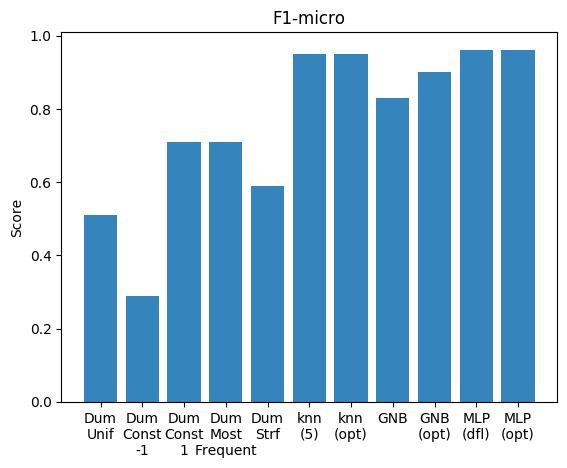

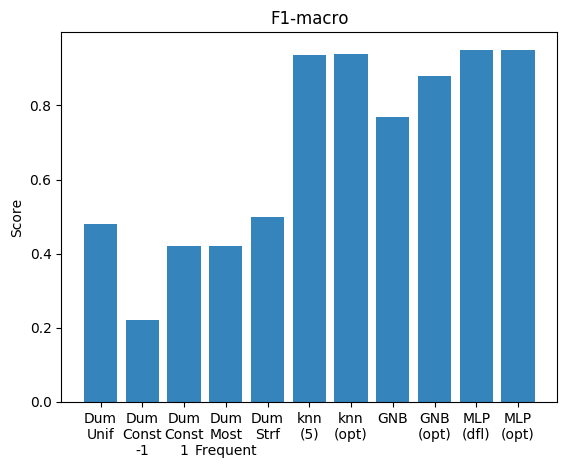

In [30]:
classifiers = ('Dum\nUnif', 'Dum\nConst\n-1', 'Dum\nConst\n1', 
               'Dum\nMost\nFrequent', 'Dum\nStrf', 
               'knn\n(5)', 'knn\n(opt)',
               'GNB', 'GNB\n(opt)',
               'MLP\n(dfl)', 'MLP\n(opt)')
classifiers_f1_micro = [0.51, 0.29, 0.71, 0.71, 0.59, 0.95, 0.95, 0.83, 0.90, 0.96, 0.9615]
classifiers_f1_macro = [0.48, 0.22, 0.42, 0.42, 0.50, 0.937, 0.939, 0.77, 0.88, 0.95, 0.95]
plot_bar(classifiers, classifiers_f1_micro, "F1-micro")
plot_bar(classifiers, classifiers_f1_macro, "F1-macro")

Συγκεντρωτικά, παρατηρούμε ότι την μεγαλύτερη βελτίωση την έχει ο GNB, της τάξης του 7%, που ήταν και η σημαντική βελτίωση που περιμέναμε από όλους τους ταξινομητές. Για τον knn και τον ΜLP, στα διαγράμματα αυτά δεν φαίνεται βελτίωση, ωστόσο σε διαγράμματα precision και recall θα βλέπαμε κάποια βελτίωση αναλογικά με το υψηλό τους score, της τάξης του 1%.  
  